# Autoregression (AR) 教程
作者：Zhenjie Lu<br />
日期: 2024-6-24<br />
摘要：2000 年 Kennedy 和 O'Hagan 提出线性自回归（AR）模型，假设低精度模型和比它高一精度的模型之间存在线性关系，即高精度数据的高斯过程回归（GP）模型可以由低精度数据的高斯过程回归模型乘比例系数和一个残差高斯过程回归组成。这个是多精度算法的一个很典型的例子。在这个教程中，主要介绍AR的模型构建以及基本应用。

首先，让我们来导入一些最基础的模块；由于仓库构造的特殊性，需要将工作目录设置到上一层，再导入相应的依赖模块

In [1]:
import sys
import os

# 将上级目录添加到Python路径中
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

AR 的底层是高斯过程（GP）所以在导入模块的时候，我们需要导入高斯过程的模块

In [2]:
import torch
import torch.nn as nn
import GaussianProcess.kernel as kernel
from GaussianProcess.cigp_v10 import cigp as GPR

2.0.1+cu118


## 1.模型定义
AR 的表达式可以表示为$z_t (x)=ρ_{t-1} z_{t-1} (x)+ δ_t (x)(t=2,3,…,s)$,t表示精度，$ρ$表示高低精度之间的精度系数，$δ$表示残差高斯过程,以下是AR的模型构建

In [3]:
class AR_demo(nn.Module):
    """
    AutoRegression model for fidelity fusion.

    Args:
        fidelity_num (int): Number of fidelity levels.
        kernel_list (list): List of kernels for each fidelity level.
        rho_init (float, optional): Initial value for rho. Defaults to 1.0.
        if_nonsubset (bool, optional): Flag indicating if non-subset training is used. Defaults to False.

    Attributes:
        gpr_list (torch.nn.ModuleList): List of Gaussian Process Regression models for each fidelity level.
        rho_list (torch.nn.ParameterList): List of rho parameters for each fidelity level.
        if_nonsubset (bool): Flag indicating if non-subset training is used.

    """

    def __init__(self, fidelity_num, kernel_list, rho_init=1.0, if_nonsubset=False):
        """
        Initialize the AR model.

        Args:
            fidelity_num (int): Number of fidelity levels.
            kernel_list (list): List of kernels for each fidelity level.
            rho_init (float, optional): Initial value for rho. Defaults to 1.0.
            if_nonsubset (bool, optional): Flag indicating if non-subset training is used. Defaults to False.

        """
        super().__init__()
        self.fidelity_num = fidelity_num
        self.gpr_list = []
        for i in range(self.fidelity_num):
            self.gpr_list.append(GPR(kernel=kernel_list[i], log_beta=1.0))
        self.gpr_list = torch.nn.ModuleList(self.gpr_list)

        self.rho_list = []
        for _ in range(self.fidelity_num - 1):
            self.rho_list.append(torch.nn.Parameter(torch.tensor(rho_init)))
        self.rho_list = torch.nn.ParameterList(self.rho_list)
        self.if_nonsubset = if_nonsubset

## 2.前向过程
AR 的前向过程是指从低精度到高精度的过程，即从低精度数据的高斯过程回归模型乘比例系数和一个残差高斯过程回归组成高精度数据的高斯过程回归; 而贝叶斯方法需要使用先验数据的分布去预测后验，所以在前向过程中，需要使用到训练的数据，在数据管理上，为了避免模型的体量过大，采用特定的数据管理类对数据进行管理。</br>
数据被分成子集数据以及非子集数据(高精度的数据的输入部分不是低精度数据的一部分),在处理这种数据的时候，需要进行虚子集部分预测，因此还需要添加一个让模型预测到相应精度的指示位(to_fidelity),模型的前向定义如下：

In [4]:
def forward_demo(self, data_manager, x_test, to_fidelity=None):
    """
    Forward pass of the AR model.

    Args:
        data_manager (DataManager): Data manager object.
        x_test (torch.Tensor): Input tensor for prediction.
        to_fidelity (int, optional): Fidelity level to predict. Defaults to None.

    Returns:
        y_pred_high (torch.Tensor): Predicted output at the highest fidelity level.
        cov_pred_high (torch.Tensor): Covariance of the predicted output at the highest fidelity level.

    """
    if to_fidelity is not None:
        fidelity_level = to_fidelity
    else:
        fidelity_level = self.fidelity_num - 1
    for i_fidelity in range(fidelity_level + 1):
        if i_fidelity == 0:
            x_train, y_train = data_manager.get_data(i_fidelity, normal=True)
            y_pred_low, cov_pred_low = self.gpr_list[i_fidelity](x_train, y_train, x_test)
            if fidelity_level == 0:
                y_pred_high = y_pred_low
                cov_pred_high = cov_pred_low
        else:
            x_train, y_train = data_manager.get_data_by_name('res-{}'.format(i_fidelity))
            y_pred_res, cov_pred_res = self.gpr_list[i_fidelity](x_train, y_train, x_test)
            y_pred_high = y_pred_low + self.rho_list[i_fidelity - 1] * y_pred_res
            cov_pred_high = cov_pred_low + (self.rho_list[i_fidelity - 1] ** 2) * cov_pred_res
            y_pred_low = y_pred_high
            cov_pred_low = cov_pred_high

    return y_pred_high, cov_pred_high

## 3.数据准备
为了验证模型,我们需要构建一些多精度的数据，这里我们基于正弦函数构造三精度的实验数据,并将实验数据储存到数据管理类中

In [5]:
from FidelityFusion_Models.MF_data import MultiFidelityDataManager
torch.manual_seed(1)
# generate the data
x_all = torch.rand(500, 1) * 20
xlow_indices = torch.randperm(500)[:300]
xlow_indices = torch.sort(xlow_indices).values
x_low = x_all[xlow_indices]
xhigh1_indices = torch.randperm(500)[:300]
xhigh1_indices = torch.sort(xhigh1_indices).values
x_high1 = x_all[xhigh1_indices]
xhigh2_indices = torch.randperm(500)[:250]
xhigh2_indices = torch.sort(xhigh2_indices).values
x_high2 = x_all[xhigh2_indices]
x_test = torch.linspace(0, 20, 100).reshape(-1, 1)

y_low = torch.sin(x_low) - 0.5 * torch.sin(2 * x_low) + torch.rand(300, 1) * 0.1 - 0.05
y_high1 = torch.sin(x_high1) - 0.3 * torch.sin(2 * x_high1) + torch.rand(300, 1) * 0.1 - 0.05
y_high2 = torch.sin(x_high2) + torch.rand(250, 1) * 0.1 - 0.05
y_test = torch.sin(x_test)

initial_data = [
    {'raw_fidelity_name': '0','fidelity_indicator': 0, 'X': x_low, 'Y': y_low},
    {'raw_fidelity_name': '1','fidelity_indicator': 1, 'X': x_high1, 'Y': y_high1},
    {'raw_fidelity_name': '2','fidelity_indicator': 2, 'X': x_high2, 'Y': y_high2},
]
fidelity_num = len(initial_data)
fidelity_manager = MultiFidelityDataManager(initial_data)

## 4.封装实例化模型
以下我们将AR模型的定义以及前向传播封装成一个类,并进行实例化

In [6]:
class AR(nn.Module):
    def __init__(self, fidelity_num, kernel_list, rho_init=1.0, if_nonsubset=False):
        super().__init__()
        self.fidelity_num = fidelity_num
        self.gpr_list = []
        for i in range(self.fidelity_num):
            self.gpr_list.append(GPR(kernel=kernel_list[i], log_beta=1.0))
        self.gpr_list = torch.nn.ModuleList(self.gpr_list)

        self.rho_list = []
        for _ in range(self.fidelity_num - 1):
            self.rho_list.append(torch.nn.Parameter(torch.tensor(rho_init)))
        self.rho_list = torch.nn.ParameterList(self.rho_list)
        self.if_nonsubset = if_nonsubset

    def forward(self, data_manager, x_test, to_fidelity=None):
        if to_fidelity is not None:
            fidelity_level = to_fidelity
        else:
            fidelity_level = self.fidelity_num - 1
        for i_fidelity in range(fidelity_level + 1):
            if i_fidelity == 0:
                x_train, y_train = data_manager.get_data(i_fidelity, normal=True)
                y_pred_low, cov_pred_low = self.gpr_list[i_fidelity](x_train, y_train, x_test)
                if fidelity_level == 0:
                    y_pred_high = y_pred_low
                    cov_pred_high = cov_pred_low
            else:
                x_train, y_train = data_manager.get_data_by_name('res-{}'.format(i_fidelity))
                y_pred_res, cov_pred_res = self.gpr_list[i_fidelity](x_train, y_train, x_test)
                y_pred_high = y_pred_low + self.rho_list[i_fidelity - 1] * y_pred_res
                cov_pred_high = cov_pred_low + (self.rho_list[i_fidelity - 1] ** 2) * cov_pred_res
                y_pred_low = y_pred_high
                cov_pred_low = cov_pred_high

        return y_pred_high, cov_pred_high

kernel_list = [kernel.SquaredExponentialKernel() for _ in range(fidelity_num)]
myAR = AR(fidelity_num = fidelity_num, kernel_list = kernel_list, rho_init=1.0, if_nonsubset=True)

## 5.模型训练
接下来我们定义模型的训练过程，并对模型进行训练。可以通过训练第$t - 1$个精度的高斯模型$𝑧_{𝑡−1}(𝑥)$、比例系数$𝜌_{𝑡−1}$和残差高斯模型$𝛿_𝑡(𝑥)$，搭建从第$𝑡 − 1$个精度到第𝑡个精度的等式，使用低精度数据对高一精度的数据进行预测, 训练时，从最低精度高斯模型$𝑧_1(𝑥)$依次向上迭代，直至最高精度$𝑧_𝑠(𝑥)$，训练出各个精度的全部参数。预测时，将输入值$𝑥_𝑡$带入最低精度模型$𝑧_1(𝑥)$，预测出最低精度的输出，再依次向上迭代，直到最高精度数据的预测

In [7]:
def train_AR(ARmodel, data_manager, max_iter=1000, lr_init=1e-1):
    """
    Trains an auto-regression model using the specified ARmodel and data_manager.

    Args:
        ARmodel (AutoRegressionModel): The auto-regression model to train.
        data_manager (DataManager): The data manager object that provides the training data.
        max_iter (int, optional): The maximum number of iterations for training. Defaults to 1000.
        lr_init (float, optional): The initial learning rate for the optimizer. Defaults to 0.1.
    """
    for i_fidelity in range(ARmodel.fidelity_num):
        optimizer = torch.optim.Adam(ARmodel.parameters(), lr=lr_init)
        if i_fidelity == 0:
            x_low, y_low = data_manager.get_data(i_fidelity, normal=True)
            for i in range(max_iter):
                optimizer.zero_grad()
                loss = ARmodel.gpr_list[i_fidelity].negative_log_likelihood(x_low, y_low)
                loss.backward()
                optimizer.step()
                print('fidelity {}, epoch {}/{}, nll: {}'.format(i_fidelity, i+1, max_iter, loss.item()), end='\r')
            print('')
        else:
            if ARmodel.if_nonsubset:
                with torch.no_grad():
                    subset_x, y_low, y_high = data_manager.get_nonsubset_fill_data(ARmodel, i_fidelity - 1, i_fidelity)
            else:
                _, y_low, subset_x, y_high = data_manager.get_overlap_input_data(i_fidelity - 1, i_fidelity, normal=True)
            for i in range(max_iter):
                optimizer.zero_grad()
                if ARmodel.if_nonsubset:
                    y_residual_mean = y_high[0] - ARmodel.rho_list[i_fidelity - 1] * y_low[0]
                    y_residual_var = abs(y_high[1] - (ARmodel.rho_list[i_fidelity - 1]**2) * y_low[1])
                else:
                    y_residual_mean = y_high - ARmodel.rho_list[i_fidelity - 1] * y_low
                    y_residual_var = None
                if i == max_iter - 1:
                    if y_residual_var is not None:
                        y_residual_var = y_residual_var.detach()
                    data_manager.add_data(raw_fidelity_name='res-{}'.format(i_fidelity), fidelity_index=None, x=subset_x.detach(), y=[y_residual_mean.detach(), y_residual_var])
                loss = ARmodel.gpr_list[i_fidelity].negative_log_likelihood(subset_x, [y_residual_mean, y_residual_var])
                loss.backward()
                optimizer.step()
                print('fidelity {}, epoch {}/{},rho {}, nll: {}'.format(i_fidelity, i+1, max_iter, ARmodel.rho_list[i_fidelity - 1].item(), loss.item()), end='\r')
            print('')

## 6.模型预测
在模型训练完成后，我们可以使用模型进行预测，这里我们使用训练数据进行预测，预测的结果与真实值进行对比,并进行可视化展示

d:\luzhenjie\mfbo_v2\GaussianProcess\cigp_v10.py:63: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:2197.)
  Gamma,_ = torch.triangular_solve(y_train, L, upper = False)


fidelity 0, epoch 200/200, nll: 237.98733520507812
fidelity 1, epoch 200/200,rho 1.013174057006836, nll: 93.9961853027343826
fidelity 2, epoch 200/200,rho 0.890105128288269, nll: 114.516143798828128


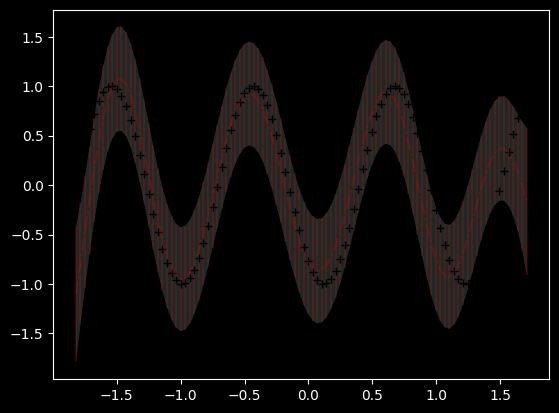

In [8]:
train_AR(myAR, fidelity_manager, max_iter=200, lr_init=1e-2)

with torch.no_grad():
    x_test = fidelity_manager.normalizelayer[myAR.fidelity_num-1].normalize_x(x_test)
    ypred, ypred_var = myAR(fidelity_manager,x_test)
    ypred, ypred_var = fidelity_manager.normalizelayer[myAR.fidelity_num-1].denormalize(ypred, ypred_var)

import matplotlib.pyplot as plt
plt.figure()
plt.errorbar(x_test.flatten(), ypred.reshape(-1).detach(), ypred_var.diag().sqrt().squeeze().detach(), fmt='r-.' ,alpha = 0.2)
plt.fill_between(x_test.flatten(), ypred.reshape(-1).detach() - ypred_var.diag().sqrt().squeeze().detach(), ypred.reshape(-1).detach() + ypred_var.diag().sqrt().squeeze().detach(), alpha = 0.2)
plt.plot(x_test.flatten(), y_test, 'k+')
plt.show()